
# 6.7-kW SyRM, saturated, disturbance estimation

This example simulates sensorless stator-flux-vector control of a saturated
6.7-kW synchronous reluctance motor drive. The saturation is not taken into
account in the control method (only in the system model). Even if the machine
has no magnets, the PM-flux disturbance estimation is enabled [#Tuo2018]_. In
this case, this PM-flux estimate lumps the effects of inductance errors.
Naturally, the PM-flux estimation can be used in PM machine drives as well.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from motulator.drive import model
import motulator.drive.control.sm as control
from motulator.drive.utils import (
    BaseValues, NominalValues, plot, Sequence, SynchronousMachinePars)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=370, I=15.5, f=105.8, P=6.7e3, tau=20.1)
base = BaseValues.from_nominal(nom, n_p=2)

Create a saturation model, see the example
:doc:`/drive_examples/obs_vhz/plot_obs_vhz_ctrl_syrm_7kw` for further details.



In [4]:
def i_s(psi_s):
    """Magnetic model for a 6.7-kW synchronous reluctance motor."""
    # Parameters
    a_d0, a_dd, S = 17.4, 373., 5  # d-axis self-saturation
    a_q0, a_qq, T = 52.1, 658., 1  # q-axis self-saturation
    a_dq, U, V = 1120., 1, 0  # Cross-saturation
    # Inverse inductance functions
    G_d = a_d0 + a_dd*np.abs(psi_s.real)**S + (
        a_dq/(V + 2)*np.abs(psi_s.real)**U*np.abs(psi_s.imag)**(V + 2))
    G_q = a_q0 + a_qq*np.abs(psi_s.imag)**T + (
        a_dq/(U + 2)*np.abs(psi_s.real)**(U + 2)*np.abs(psi_s.imag)**V)
    # Stator current
    return G_d*psi_s.real + 1j*G_q*psi_s.imag

Configure the system model.



In [5]:
mdl_par = SynchronousMachinePars(n_p=2, R_s=.54)
machine = model.SynchronousMachine(mdl_par, i_s=i_s, psi_s0=0)
# Magnetically linear SyRM model for comparison
# mdl_par = SynchronousMachinePars(
#     n_p=2, R_s=.54, L_d=37e-3, L_q=6.2e-3, psi_f=0)
# machine = model.SynchronousMachine(mdl_par)
mechanics = model.StiffMechanicalSystem(J=.015)
converter = model.VoltageSourceConverter(u_dc=540)
mdl = model.Drive(converter, machine, mechanics)

Configure the control system. The saturation is not taken into account.
Furthermore, the inductance estimates L_d and L_q are intentionally set to
lower values in order to demonstrate the PM-flux disturbance estimation.



In [6]:
par = SynchronousMachinePars(
    n_p=2, R_s=.54, L_d=.7*37e-3, L_q=.8*6.2e-3, psi_f=0)
# Disable MTPA since the control system does not consider the saturation
cfg = control.FluxTorqueReferenceCfg(
    par, max_i_s=2*base.i, k_u=.9, min_psi_s=base.psi, max_psi_s=base.psi)
ctrl = control.FluxVectorControl(par, cfg, J=.015, sensorless=True)
# Since the saturation is not considered in the control system, the speed
# estimation bandwidth is set to a lower value. Furthermore, the PM-flux
# disturbance estimation is enabled at speeds above 2*pi*20 rad/s (electrical).
ctrl.observer = control.Observer(
    control.ObserverCfg(
        par,
        alpha_o=2*np.pi*40,
        k_f=lambda w_m: max(.05*(np.abs(w_m) - 2*np.pi*20), 0),
        sensorless=True))

Set the speed reference and the external load torque.



In [7]:
# Speed reference (electrical rad/s)
times = np.array([0, .125, .25, .375, .5, .625, .75, .875, 1])*4
values = np.array([0, 0, 1, 1, 0, -1, -1, 0, 0])*base.w
ctrl.ref.w_m = Sequence(times, values)
# External load torque
times = np.array([0, .125, .125, .875, .875, 1])*4
values = np.array([0, 0, 1, 1, 0, 0])*nom.tau
mdl.mechanics.tau_L = Sequence(times, values)

Create the simulation object and simulate it.



In [8]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=4)

Plot results in per-unit values. The transient after t = 0.5 s is due to the
errors in the inductances. The PM-flux estimate compensates for these errors.



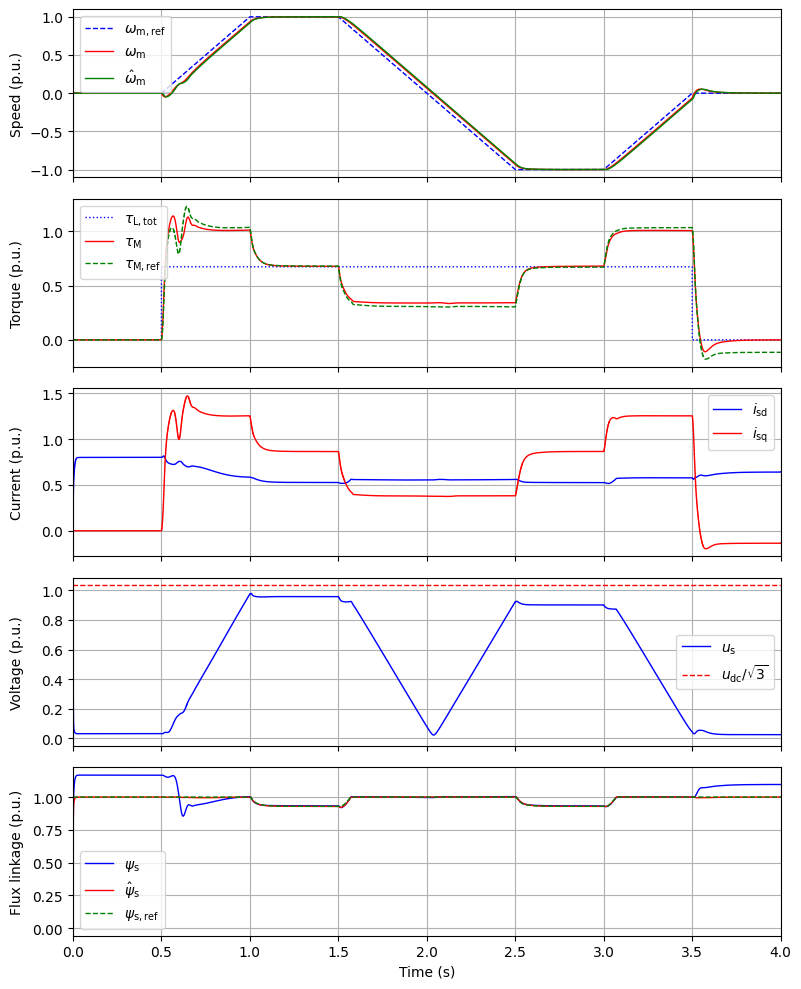

In [9]:
plot(sim, base)

Plot the flux linkages and the PM-flux disturbance estimate. Due to the
inductance errors and the magnetic saturation, it is nonzero even if the
machine has no magnets.



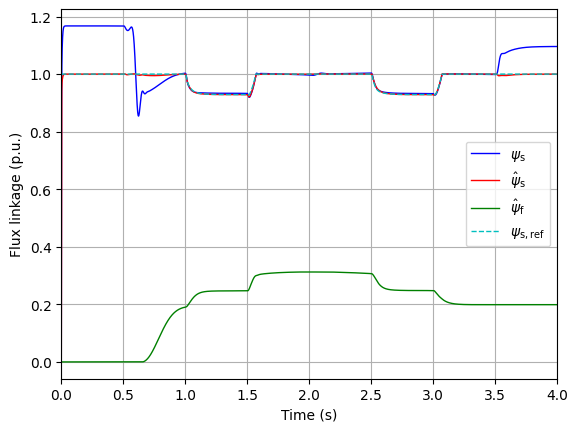

In [10]:
mdl = sim.mdl  # Continuous-time data
ctrl = sim.ctrl.data  # Discrete-time data
ctrl.t = ctrl.ref.t  # Discrete time
plt.figure()
plt.plot(
    mdl.machine.data.t,
    np.abs(mdl.machine.data.psi_s)/base.psi,
    label=r"$\psi_\mathrm{s}$")
plt.plot(
    ctrl.t, np.abs(ctrl.fbk.psi_s)/base.psi, label=r"$\hat{\psi}_\mathrm{s}$")
plt.plot(ctrl.t, ctrl.fbk.psi_f/base.psi, label=r"$\hat{\psi}_\mathrm{f}$")
plt.plot(ctrl.t, ctrl.ref.psi_s/base.psi, "--", label=r"$\psi_\mathrm{s,ref}$")
plt.xlim(0, 4)
plt.xlabel("Time (s)")
plt.ylabel("Flux linkage (p.u.)")
plt.legend()
plt.show()

.. rubric:: References

.. [#Tuo2018] Tuovinen, Awan, Kukkola, Saarakkala, Hinkkanen, "Permanent-
   magnet flux adaptation for sensorless synchronous motor drives," Proc.
   IEEE SLED, 2018, https://doi.org/10.1109/SLED.2018.8485899

